# Business Problem:
A group of customers were given an offer in person that they can get a loan at discounted rate and
processing fee will be waived off. A pilot campaign was conducted to get response from customers
whether they are interested in taking out a loan or not. Response was recorded and data was collected.

### Need to Do

- [x] Build a model to predict whether customers will be interested in taking out a loan or not.
- [x] Identifying features which are most important
- [ ] In case of black box models e.g. Random forest use SHAP, LIME to figure out features affecting the target variable
- [x] Try Unsupervised clustering models
- [ ] Generate synthetic data for model.
- [x] Approaching a customer has costs involved with it, hence find the profitable segments so that more customized marketing can be done.
- [ ] Need to write inferences what is going on
- [x] Bucketing Age and SCR

Variables involved: `Customer_id`, `Age`, `Gender`, `Balance`, `Occupation`, `No of Credit transaction`, `SCR`, `Holding period`

Bucketed  
Final visualization  
age_d  == 1,2,3,4 vs Target, SCR , _Balance

> ## Understanding Variables


- `Holding Period` (How long the customer is able to hold the money in his account.. So, if they have some existing expenses like a loan EMI or any other monthly expense which gets deducted, usually the first week of every month, hence it makes the balance in the account lower during initial days of the month itself.Higher the holding period, more stable their money is in the account.)

- `SCR` SCR is a score given to a customer for a particular product ( in this case loan ) based on certain parameters, to know whether how likely that customer is to buy that product.. so, higher the score, higher the probability, the customer will buy it.. ###SCR propensity of a customer to respond to a digital marketing


##### Changes v6:
1. Now All Models measure recall on same testing data

2. Fixed Sampling mistake

3. Redefined `print_classification_report` as `classification_report` for better clarity and ease of use

4. Visualized Decision Trees

5. Implemented SVC

6. Implemented KNN which provided great results with default parameters

##### Changes v7:
1. Fit Random Forest Models

2. Fit XgBoost Models

##### Changes v9:
1. Added cross validation

2. Added ROC plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc, plot_roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

import xgboost as xgb

In [2]:
#from pandasgui import show

In [3]:
data = pd.read_csv('Model_data.csv')
#show(data)

In [4]:
data.Balance = data.Balance.astype('int32') #Truncating decimals

In [5]:
data.head()

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period
0,0,41,M,91519,SELF-EMP,38,926,15
1,0,52,M,117288,SAL,17,768,13
2,0,31,F,259827,SENP,8,816,5
3,0,45,F,26677,PROF,14,353,18
4,0,39,F,43440,SENP,1,751,31


In [6]:
data.Balance.describe()

count    2.000000e+04
mean     1.461808e+05
std      1.698125e+05
min      0.000000e+00
25%      2.373650e+04
50%      7.975550e+04
75%      2.173100e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [7]:
data.shape

(20000, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Target          20000 non-null  int64 
 1   Age             20000 non-null  int64 
 2   Gender          20000 non-null  object
 3   Balance         20000 non-null  int32 
 4   Occupation      20000 non-null  object
 5   No_OF_CR_TXNS   20000 non-null  int64 
 6   SCR             20000 non-null  int64 
 7   Holding_Period  20000 non-null  int64 
dtypes: int32(1), int64(5), object(2)
memory usage: 1.1+ MB


`Gender` and `Occupation` are categorical varibles stored as object type

**EDA**

No Strong correlations measured except for mild ones in `Holding_period` and other variables

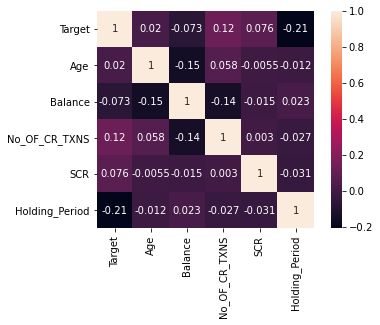

In [9]:
sns.heatmap(data.corr(), annot=True, square=True) # No strong correlations seen overall
plt.show()

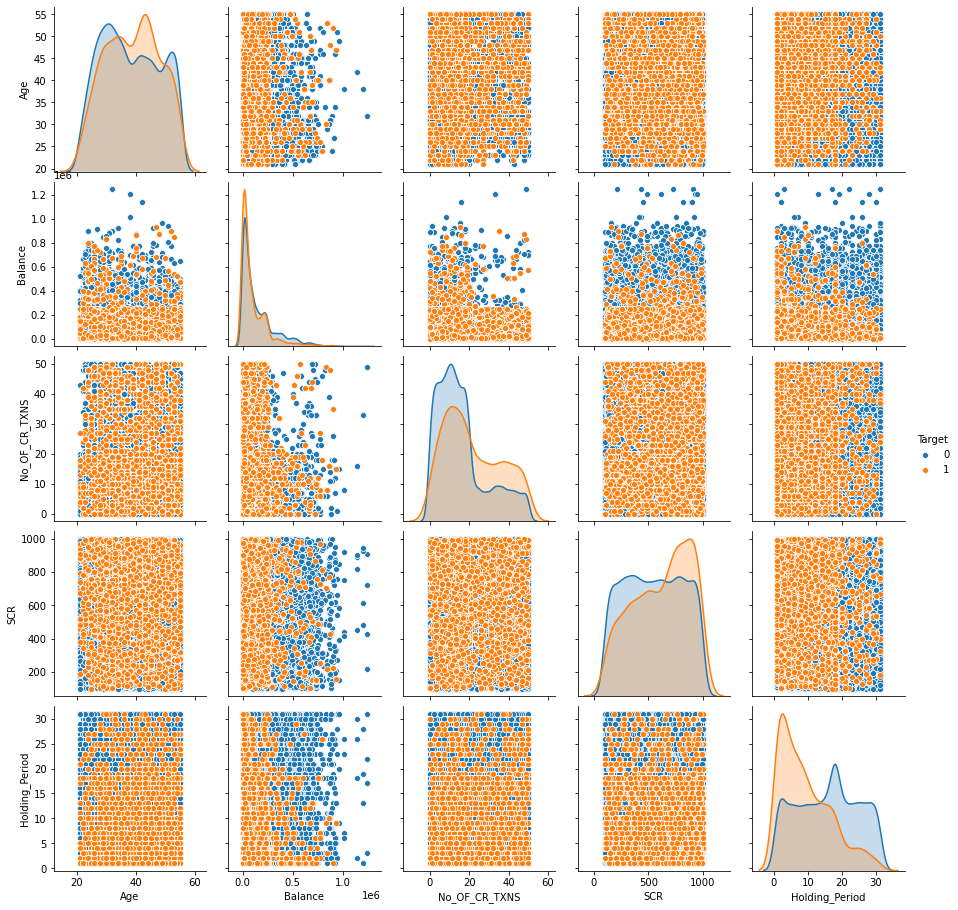

In [10]:
sns.pairplot(data, hue='Target')
plt.show()

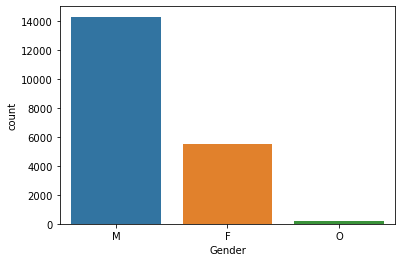

In [11]:
sns.countplot(x = data.Gender)
plt.show()

In [12]:
data.Gender.unique()

array(['M', 'F', 'O'], dtype=object)

In [13]:
data.Occupation.unique()

array(['SELF-EMP', 'SAL', 'SENP', 'PROF'], dtype=object)

In [14]:
data.Gender.value_counts()

M    14279
F     5525
O      196
Name: Gender, dtype: int64

In [15]:
data.drop(data.Gender[data.Gender== 'O'].index, axis = 0, inplace= True) # Removed 196 rows with `Gender` = 'O'

In [16]:
data.shape

(19804, 8)

In [17]:
data.Balance.describe()

count    1.980400e+04
mean     1.465609e+05
std      1.694485e+05
min      0.000000e+00
25%      2.399900e+04
50%      8.035100e+04
75%      2.183090e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [18]:
# sns.histplot(data.Age)

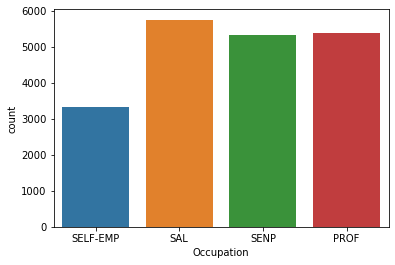

In [19]:
sns.countplot(x = data.Occupation)

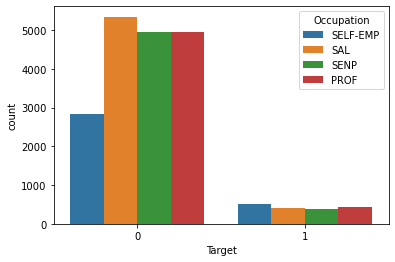

In [20]:
sns.countplot(x=data.Target, hue=data.Occupation) ## Self employed are much more likely to take loans

C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


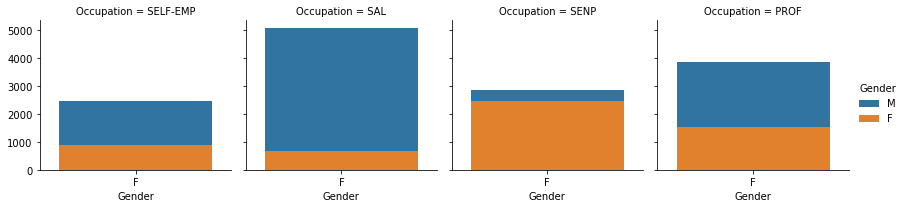

In [21]:
g = sns.FacetGrid(data, col='Occupation', hue="Gender")
plt.grid(True)
g.map(sns.countplot, "Gender", alpha=1)
g.add_legend()
plt.grid((False))

--------------------------

In [22]:
# sns.histplot(data.No_OF_CR_TXNS)

In [23]:
data.No_OF_CR_TXNS.describe()

count    19804.000000
mean        16.563169
std         12.928214
min          0.000000
25%          7.000000
50%         13.000000
75%         21.000000
max         50.000000
Name: No_OF_CR_TXNS, dtype: float64

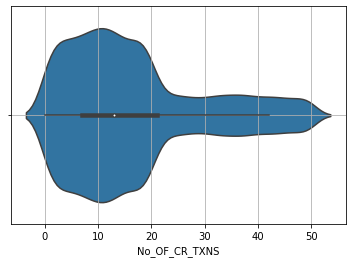

In [24]:
sns.violinplot(x=data.No_OF_CR_TXNS)
plt.grid(True)

In [25]:
# len(data[data.No_OF_CR_TXNS==0].index)

In [26]:
# data.drop(index=data[data.No_OF_CR_TXNS==0].index, axis=0)

------------------

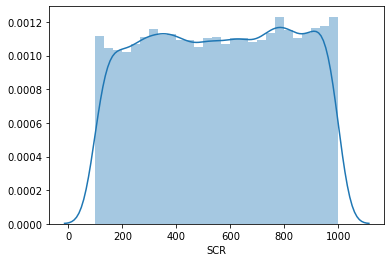

In [27]:
# sns.displot(data.SCR, kind = 'kde')
sns.distplot(data.SCR)
plt.show()

In [28]:
data.SCR.describe()

count    19804.000000
mean       557.115987
std        260.562729
min        100.000000
25%        332.000000
50%        560.500000
75%        784.250000
max        999.000000
Name: SCR, dtype: float64

In [29]:
# sns.histplot(data.Holding_Period)

In [30]:
data3 = data

##### End of Exploratory Data Analysis
-----------
----------

> ### Create a function for easy report printing

In [31]:
# A class for pretty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# function for validation on test data   
def classification_report(y_true, y_prediction, type_of_data='Enter Over/Under/Original sampled', type_of_classifier='ClassifierName'):
    """Print Classification report"""
    
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    
    print('Classification Report on Testing Data:\n'+ color.BOLD + type_of_data, 'data\n'+color.END+color.RED+color.BOLD+type_of_classifier,'Classifier'+color.END+color.END)
    print()
    print('---------------------------------------')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1 score: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print('---------------------------------------')
    print()


# A function for cross-validation report    
def cross_val_report(classifier, train_data, train_label, cv=10, scoring=['recall','precision', 'f1','accuracy']):
    
    score = cross_validate(classifier, train_data, train_label, cv=cv, scoring= scoring)
    recall = np.mean(score['test_recall'])
    precision = np.mean(score['test_precision'])
    f1 = np.mean(score['test_f1'])
    accuracy= np.mean(score['test_accuracy'])
    print('Cross Validation Report')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print()
    print("*Mean values presented")
    print('---------------------------------------')

**Create the first set of training and test data on imbalanced data**

In [32]:
df = pd.get_dummies(data, columns=['Gender','Occupation'], drop_first = True)
df.head()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,0,41,91519,38,926,15,1,0,1,0
1,0,52,117288,17,768,13,1,1,0,0
2,0,31,259827,8,816,5,0,0,0,1
3,0,45,26677,14,353,18,0,0,0,0
4,0,39,43440,1,751,31,0,0,0,1


>**Creating a model with Original Unbalanced data and measuring metrics**

In [33]:
X_original = df.iloc[:,1:]
y_original = df.iloc[:,0]

In [34]:
X_original

,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,41,91519,38,926,15,1,0,1,0
1,52,117288,17,768,13,1,1,0,0
2,31,259827,8,816,5,0,0,0,1
3,45,26677,14,353,18,0,0,0,0
4,39,43440,1,751,31,0,0,0,1
...,...,...,...,...,...,...,...,...,...
19995,23,67612,20,164,27,0,0,0,1
19996,34,472365,8,124,1,0,0,0,0
19997,42,100642,4,263,1,1,1,0,0
19998,36,29950,10,345,31,1,0,0,1


In [35]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original,y_original, shuffle = ['True'], stratify=y_original)

Classification Report on Testing Data:
Original data
Decision Tree Classifier

---------------------------------------
Recall: 0.1288056206088993
Precision: 0.6179775280898876
F1 score: 0.2131782945736434
Accuracy: 0.9179963643708342
---------------------------------------



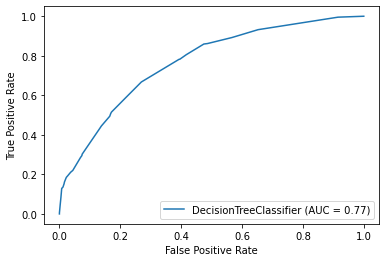

In [36]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train_orig, y_train_orig)
y_prediction_orig = clf.predict(X_test_orig)
classification_report(y_test_orig, y_prediction_orig, 'Original', 'Decision Tree')
plot_roc_curve(clf, X_test_orig, y_test_orig)
plt.show()
# cross_val_report(clf, y_test_orig,y_under_prediction.reshape(1,-1))

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
confusion_matrix(y_test_orig, y_prediction_orig)

array([[4490,   34],
       [ 372,   55]], dtype=int64)

In [39]:
# fig = plt.figure(figsize=(50,20))
# _ = plot_tree(clf, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

-----------

>**Create undersampled data and fit a model**

In [40]:
X_under_train, y_under_train = NearMiss().fit_resample(X_train_orig, y_train_orig)

In [41]:
data[data.Target==1].shape

(1709, 8)

In [42]:
X_under_train.shape, y_under_train.shape

((2564, 9), (2564,))

Classification Report on Testing Data:
Undersampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.7564402810304449
Precision: 0.09088351153629713
F1 score: 0.1622707862346144
Accuracy: 0.32639870733185217
---------------------------------------



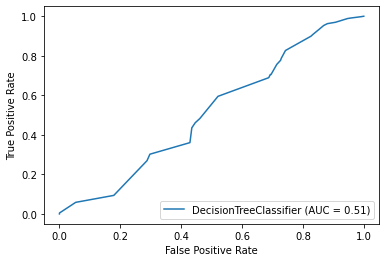

In [43]:
clf_under_sampled = DecisionTreeClassifier(max_depth = 5)
clf_under_sampled.fit(X_under_train, y_under_train)
y_under_prediction = clf_under_sampled.predict(X_test_orig)
classification_report(y_test_orig,y_under_prediction, 'Undersampled', 'Decision Tree')
plot_roc_curve(clf_under_sampled, X_test_orig, y_test_orig)

In [44]:
# cross_val_report(clf_under_sampled, y_test_orig,y_under_prediction)

## crossval here causes unbalanced split

In [45]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_under_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

--------------------

> Model on  an oversampled dataset

In [126]:
X_over_train, y_over_train = SMOTE().fit_resample(X_train_orig, y_train_orig)

Classification Report on Testing Data:
Oversampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.4215456674473068
Precision: 0.15625
F1 score: 0.2279924002533249
Accuracy: 0.7537871137144011
---------------------------------------



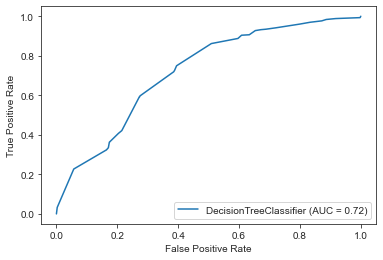

In [127]:
clf_over_sampled = DecisionTreeClassifier(max_depth = 5)
clf_over_sampled.fit(X_over_train, y_over_train)
y_over_predict = clf_over_sampled.predict(X_test_orig)
classification_report(y_test_orig, y_over_predict, 'Oversampled', 'Decision Tree')
plot_roc_curve(clf_over_sampled, X_test_orig, y_test_orig)

In [128]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_over_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

---------------

In [129]:
print("Original:     "+color.BOLD+ "X_original,y_original"+color.END+"::  X_train_orig, X_test_orig, y_train_orig, y_test_orig")
print()
print("Undersampled:"+color.BOLD+ " X_under, y_under"+color.END+"     ::  X_under_train, y_under_train")
print()
print("Oversampled:"+color.BOLD+ "  X_over, y_over"+color.END+"       ::  X_over_train, y_over_train")

Original:     X_original,y_original::  X_train_orig, X_test_orig, y_train_orig, y_test_orig

Undersampled: X_under, y_under     ::  X_under_train, y_under_train

Oversampled:  X_over, y_over       ::  X_over_train, y_over_train


The above datasets can be better sampled by adjusting hyper-parameters of NearMiss and SMOTE, or other methods of sampling could be used

-----------
-----------

### SVM Classifiers applied

*SVC fails to fit on original dataset, possibly because of unbalance*

Classification Report on Testing Data:
Undersampled data
SVM Classifier

---------------------------------------
Recall: 0.4894613583138173
Precision: 0.07051282051282051
F1 score: 0.12326747272191095
Accuracy: 0.39951524944455663
---------------------------------------

Cross Validation Report
Recall: 0.5117005813953488
Precision: 0.836045585980186
F1: 0.6326115484037623
Accuracy: 0.7027693336575875

*Mean values presented
---------------------------------------


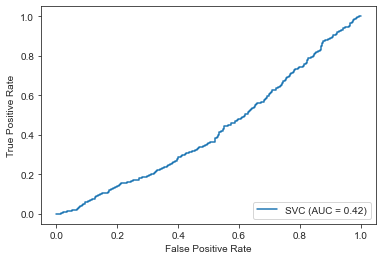

In [130]:
clf_svc0 = SVC()
clf_svc0.fit(X_under_train, y_under_train)
y_predict = clf_svc0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'SVM')
plot_roc_curve(clf_svc0, X_test_orig, y_test_orig)
cross_val_report(clf_svc0, X_under_train, y_under_train)

In [131]:
# %%time
# # Will take LONG Time for Training
# clf_svc1 = SVC()
# clf_svc1.fit(X_over_train, y_over_train)
# y_predict = clf_svc1.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Oversampled', 'SVM')
# plot_roc_curve(clf_svc1, X_test_orig, y_test_orig)
# cross_val_report(clf_svc1, X_under_train, y_under_train)

-------------
--------------------

Classification Report on Testing Data:
Original data
KNN Classifier

---------------------------------------
Recall: 0.09601873536299765
Precision: 0.3504273504273504
F1 score: 0.15073529411764705
Accuracy: 0.9066855180771561
---------------------------------------

Cross Validation Report
Recall: 0.6240128391472869
Precision: 0.7156164044916156
F1: 0.6627710076031459
Accuracy: 0.6775291828793775

*Mean values presented
---------------------------------------


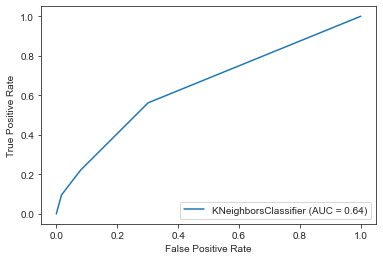

In [132]:
clf_KNN0 = KNeighborsClassifier()
clf_KNN0.fit(X_train_orig, y_train_orig)
y_predict= clf_KNN0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'KNN')
plot_roc_curve(clf_KNN0, X_test_orig, y_test_orig)
cross_val_report(clf_KNN0, X_under_train, y_under_train)

-----------

Classification Report on Testing Data:
Undersampled data
KNN Classifier

---------------------------------------
Recall: 0.6908665105386417
Precision: 0.07662337662337662
F1 score: 0.13794715922375497
Accuracy: 0.2553019592001616
---------------------------------------

Cross Validation Report
Recall: 0.6240128391472869
Precision: 0.7156164044916156
F1: 0.6627710076031459
Accuracy: 0.6775291828793775

*Mean values presented
---------------------------------------


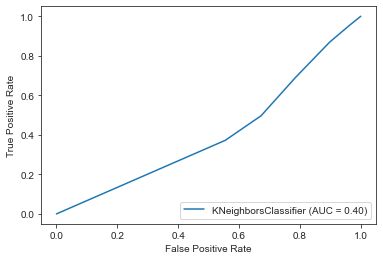

In [133]:
clf_KNN1 = KNeighborsClassifier()
clf_KNN1.fit(X_under_train, y_under_train)
y_predict= clf_KNN1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'KNN')
plot_roc_curve(clf_KNN1, X_test_orig, y_test_orig)
cross_val_report(clf_KNN1, X_under_train, y_under_train)

----------
----------

### Random Forest Classifier Models

Classification Report on Testing Data:
Original data
Random Forest Classifier

---------------------------------------
Recall: 0.1451990632318501
Precision: 0.62
F1 score: 0.2352941176470588
Accuracy: 0.9186023025651383
---------------------------------------

Cross Validation Report
Recall: 0.7894137596899224
Precision: 0.8028483378365981
F1: 0.7945524679267558
Accuracy: 0.7956164883268483

*Mean values presented
---------------------------------------


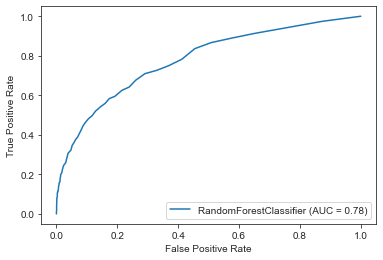

In [134]:
clf_rf0 = RandomForestClassifier()
clf_rf0.fit(X_train_orig, y_train_orig)
y_predict= clf_rf0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Random Forest')
plot_roc_curve(clf_rf0, X_test_orig, y_test_orig)
cross_val_report(clf_rf0, X_under_train, y_under_train)

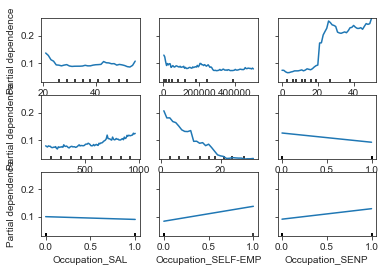

In [135]:
plot_partial_dependence(clf_rf0, X_test_orig, X_test_orig.columns)

-------------

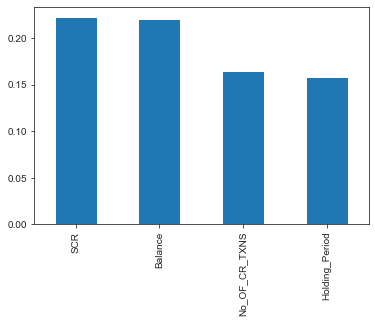

In [136]:
(pd.Series(clf_rf0.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='bar'))

## **RFE Trial**

In [137]:
from sklearn.feature_selection import RFE

In [138]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=4)
rfe = rfe.fit(X_over_train, y_over_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True False False False False]
[2 1 1 1 1 5 3 6 4]


In [139]:
categorical_features_indices = np.where(X_train_orig.dtypes != np.float)[0]

In [140]:
help(CatBoostClassifier)

Help on class CatBoostClassifier in module catboost.core:

class CatBoostClassifier(CatBoost)
 |  CatBoostClassifier(iterations=None, learning_rate=None, depth=None, l2_leaf_reg=None, model_size_reg=None, rsm=None, loss_function=None, border_count=None, feature_border_type=None, per_float_feature_quantization=None, input_borders=None, output_borders=None, fold_permutation_block=None, od_pval=None, od_wait=None, od_type=None, nan_mode=None, counter_calc_method=None, leaf_estimation_iterations=None, leaf_estimation_method=None, thread_count=None, random_seed=None, use_best_model=None, best_model_min_trees=None, verbose=None, silent=None, logging_level=None, metric_period=None, ctr_leaf_count_limit=None, store_all_simple_ctr=None, max_ctr_complexity=None, has_time=None, allow_const_label=None, target_border=None, classes_count=None, class_weights=None, auto_class_weights=None, class_names=None, one_hot_max_size=None, random_strength=None, name=None, ignored_features=None, train_dir=None, 

In [141]:
X_train_orig.columns

Index(['Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period', 'Gender_M',
       'Occupation_SAL', 'Occupation_SELF-EMP', 'Occupation_SENP'],
      dtype='object')

Classification Report on Testing Data:
Undersampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8009367681498829
Precision: 0.10301204819277109
F1 score: 0.18254603682946358
Accuracy: 0.3813371036154312
---------------------------------------

Cross Validation Report
Recall: 0.7902010658914729
Precision: 0.8028733184354628
F1: 0.795128881282551
Accuracy: 0.7960101532101167

*Mean values presented
---------------------------------------


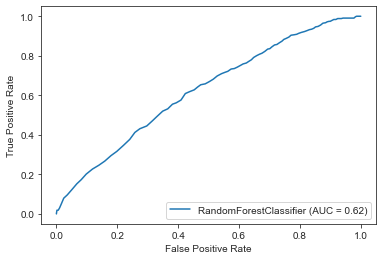

In [142]:
clf_rf1 = RandomForestClassifier()
clf_rf1.fit(X_under_train, y_under_train)
y_predict= clf_rf1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Random Forest')
plot_roc_curve(clf_rf1, X_test_orig, y_test_orig)
cross_val_report(clf_rf1, X_under_train, y_under_train)

-------------

In [143]:
clf_rf2 = RandomForestClassifier()

Classification Report on Testing Data:
Oversampled data
Random Forest Classifier

---------------------------------------
Recall: 0.7915690866510539
Precision: 0.10226928895612708
F1 score: 0.18113612004287247
Accuracy: 0.382750959402141
---------------------------------------

Cross Validation Report
Recall: 0.7941012596899225
Precision: 0.7998741445228489
F1: 0.7953903580014734
Accuracy: 0.7956240880350195

*Mean values presented
---------------------------------------


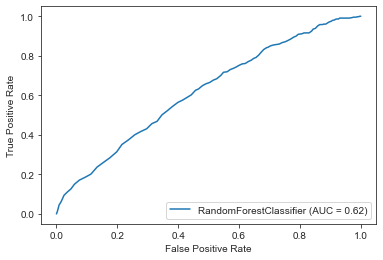

In [144]:
clf_rf2.fit(X_under_train, y_under_train)
y_predict= clf_rf2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Random Forest')
plot_roc_curve(clf_rf2, X_test_orig, y_test_orig)
cross_val_report(clf_rf2, X_under_train, y_under_train)

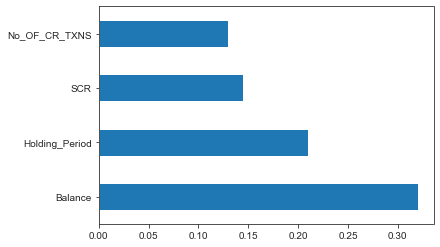

In [145]:
(pd.Series(clf_rf2.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='barh'))

----------
----------------

In [146]:
# rfe = RFE(KNeighborsClassifier(), n_features_to_select=4)
# rfe = rfe.fit(X_train_orig, y_train_orig)
# # summarize the selection of the attributes
# print(rfe.saupport_)
# print(rfe.ranking_)

------
------

In [147]:
lr0 = LogisticRegression(max_iter=1000)
lr0.fit(X_train_orig, y_train_orig)
y_predict= lr0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Logistic Regression')
plot_roc_curve(lr0, X_test_orig, y_test_orig)
cross_val_report(lr0, X_under_train, y_under_train)

NameError: name 'LogisticRegression' is not defined

In [148]:
lr1 = LogisticRegression(max_iter=100)
lr1.fit(X_under_train, y_under_train)
y_predict= lr1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

NameError: name 'LogisticRegression' is not defined

In [149]:
lr2 = LogisticRegression(max_iter=100)
lr2.fit(X_over_train, y_over_train)
y_predict= lr2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

NameError: name 'LogisticRegression' is not defined

------
------

Classification Report on Testing Data:
Oversampled data
KNN Classifier

---------------------------------------
Recall: 0.48009367681498827
Precision: 0.1479076479076479
F1 score: 0.22614451185879758
Accuracy: 0.7166229044637447
---------------------------------------

Cross Validation Report
Recall: 0.6240128391472869
Precision: 0.7156164044916156
F1: 0.6627710076031459
Accuracy: 0.6775291828793775

*Mean values presented
---------------------------------------


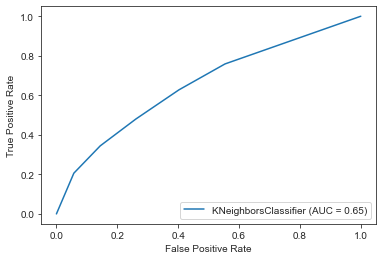

In [150]:
clf_KNN2 = KNeighborsClassifier()
clf_KNN2.fit(X_over_train, y_over_train)
y_predict= clf_KNN2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'KNN')
plot_roc_curve(clf_KNN2, X_test_orig, y_test_orig)
cross_val_report(clf_KNN2, X_under_train, y_under_train)

**_Segment the customer with prob >90, 80>prob>90, 70>prob>80, 60>prob>70 and so on_**

In [151]:
predict_prob = clf_KNN2.predict_proba(X_test_orig)
predict_prob.shape
# print more significant digits here

(4951, 2)

In [152]:
# predict_prob

In [153]:
predictions = pd.DataFrame(predict_prob, columns=[0, 'PredictionProb'])

In [154]:
# predictions.head()

In [155]:
predictions_prob = predictions.drop(0, axis=1)

In [156]:
y = pd.DataFrame(y_test_orig, columns = ['Target'])
y = y.reset_index(drop=True)

In [157]:
error = y.Target- predictions_prob.PredictionProb

In [158]:
# This series indicate the error, closer to zero values mean better prediction
# positive mean that my model should have predicted loan taker, but did not
# negative means that model should have predicted NOT a loan taker, but did predict as such

In [159]:
# target - probablity

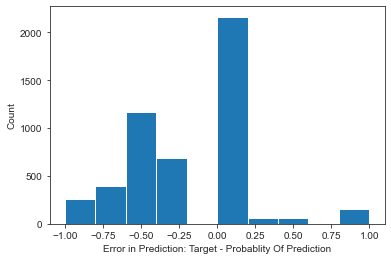

In [160]:
plt.hist(error)
plt.xlabel('Error in Prediction: Target - Probablity Of Prediction')
plt.ylabel("Count")
plt.show()

## PRE-BUCKETING VISUALIZATIONS FOR INFERENCES

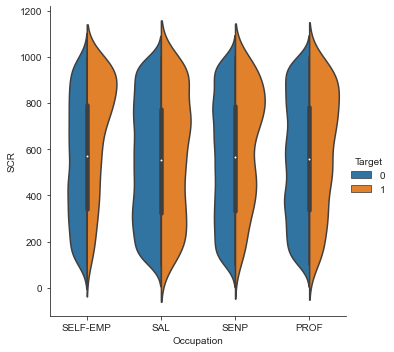

In [162]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, kind = "violin", split = True)
plt.show()

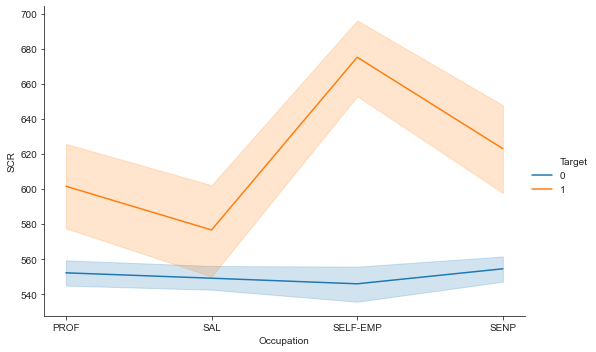

In [163]:
sns.relplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=1.5, kind = "line")
plt.show()

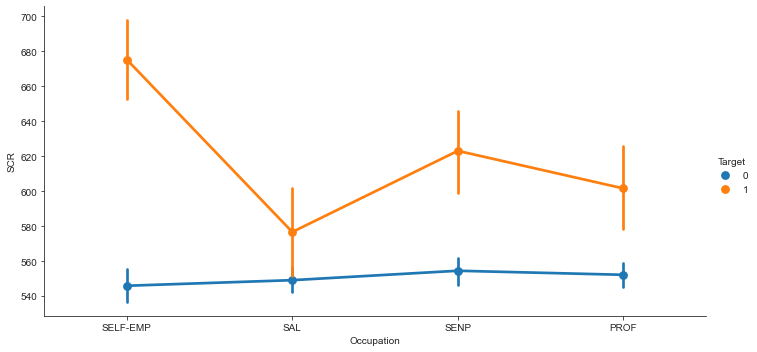

In [164]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=2.0, kind = "point")
plt.show()

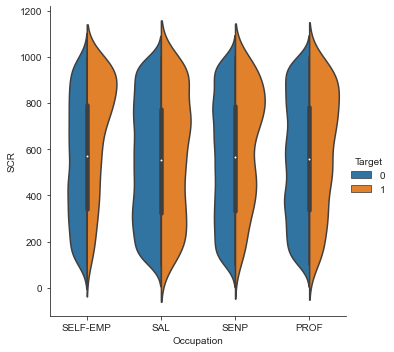

In [165]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, kind = "violin", split = True)
plt.show()

The model is good, make few mistakes

In [166]:
data1 = data.copy()

## Bucketing for AGE values

In [167]:
data1['Ageb'] = pd.qcut(data['Age'], q=4)

In [168]:
data1.head()

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period,Ageb
0,0,41,M,91519,SELF-EMP,38,926,15,"(38.0, 46.0]"
1,0,52,M,117288,SAL,17,768,13,"(46.0, 55.0]"
2,0,31,F,259827,SENP,8,816,5,"(30.0, 38.0]"
3,0,45,F,26677,PROF,14,353,18,"(38.0, 46.0]"
4,0,39,F,43440,SENP,1,751,31,"(38.0, 46.0]"


In [169]:
data1.Ageb.value_counts()

(30.0, 38.0]      5188
(20.999, 30.0]    5136
(46.0, 55.0]      4936
(38.0, 46.0]      4544
Name: Ageb, dtype: int64

In [170]:
data1.dtypes

Target               int64
Age                  int64
Gender              object
Balance              int32
Occupation          object
No_OF_CR_TXNS        int64
SCR                  int64
Holding_Period       int64
Ageb              category
dtype: object

In [171]:
data1.Ageb

0          (38.0, 46.0]
1          (46.0, 55.0]
2          (30.0, 38.0]
3          (38.0, 46.0]
4          (38.0, 46.0]
              ...      
19995    (20.999, 30.0]
19996      (30.0, 38.0]
19997      (38.0, 46.0]
19998      (30.0, 38.0]
19999      (30.0, 38.0]
Name: Ageb, Length: 19804, dtype: category
Categories (4, interval[float64]): [(20.999, 30.0] < (30.0, 38.0] < (38.0, 46.0] < (46.0, 55.0]]

In [172]:
data1.head(5)

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period,Ageb
0,0,41,M,91519,SELF-EMP,38,926,15,"(38.0, 46.0]"
1,0,52,M,117288,SAL,17,768,13,"(46.0, 55.0]"
2,0,31,F,259827,SENP,8,816,5,"(30.0, 38.0]"
3,0,45,F,26677,PROF,14,353,18,"(38.0, 46.0]"
4,0,39,F,43440,SENP,1,751,31,"(38.0, 46.0]"


In [173]:
# sns.pairplot(data1, hue='Target')

In [174]:
data1 = pd.get_dummies(data1)

In [175]:
data1.head(2)

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_F,Gender_M,Occupation_PROF,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP,"Ageb_(20.999, 30.0]","Ageb_(30.0, 38.0]","Ageb_(38.0, 46.0]","Ageb_(46.0, 55.0]"
0,0,41,91519,38,926,15,0,1,0,0,1,0,0,0,1,0
1,0,52,117288,17,768,13,0,1,0,1,0,0,0,0,0,1


In [176]:
data2 = data1.copy()

In [177]:
data1.columns

Index(['Target', 'Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period',
       'Gender_F', 'Gender_M', 'Occupation_PROF', 'Occupation_SAL',
       'Occupation_SELF-EMP', 'Occupation_SENP', 'Ageb_(20.999, 30.0]',
       'Ageb_(30.0, 38.0]', 'Ageb_(38.0, 46.0]', 'Ageb_(46.0, 55.0]'],
      dtype='object')

In [178]:
cols = ['Ageb_(30.0, 38.0]', 'Ageb_(20.999, 30.0]','Ageb_(46.0, 55.0]','Ageb_(38.0, 46.0]']

def func1(x):
    if x ==1:
        return 1
def func2(x):
    if x ==1:
        return 2

def func3(x):
    if x ==1:
        return 3

def func4(x):
    if x ==1:
        return 4


data1['age_d'] = data1['Ageb_(30.0, 38.0]'].apply(func1)
data1['age_d'] = data1['Ageb_(20.999, 30.0]'].apply(func2)
data1['age_d'] = data1['Ageb_(46.0, 55.0]'].apply(func3)
data1['age_d'] = data1['Ageb_(38.0, 46.0]'].apply(func4)

In [179]:
for ind, row in data1.iterrows():
    if row['Ageb_(20.999, 30.0]'] ==1:
        data1.loc[ind, 'age_d'] = 1
    elif row['Ageb_(30.0, 38.0]'] ==1:
        data1.loc[ind, 'age_d'] = 2
    elif row['Ageb_(38.0, 46.0]'] ==1:
        data1.loc[ind, 'age_d'] = 3
    elif row['Ageb_(46.0, 55.0]'] ==1:
        data1.loc[ind, 'age_d'] = 4

In [180]:
data1.age_d.value_counts()

2.0    5188
1.0    5136
4.0    4936
3.0    4544
Name: age_d, dtype: int64

In [181]:
data1.age_d = data1.age_d.astype('int32')

In [182]:
data1.head()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_F,Gender_M,Occupation_PROF,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP,"Ageb_(20.999, 30.0]","Ageb_(30.0, 38.0]","Ageb_(38.0, 46.0]","Ageb_(46.0, 55.0]",age_d
0,0,41,91519,38,926,15,0,1,0,0,1,0,0,0,1,0,3
1,0,52,117288,17,768,13,0,1,0,1,0,0,0,0,0,1,4
2,0,31,259827,8,816,5,1,0,0,0,0,1,0,1,0,0,2
3,0,45,26677,14,353,18,1,0,1,0,0,0,0,0,1,0,3
4,0,39,43440,1,751,31,1,0,0,0,0,1,0,0,1,0,3


## POST-BUCKETING VISUALIZATIONS FOR INFERENCES

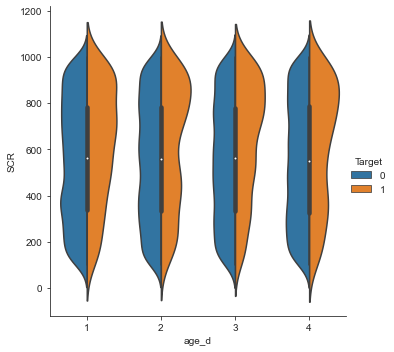

In [183]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

In [184]:
data1.columns

Index(['Target', 'Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period',
       'Gender_F', 'Gender_M', 'Occupation_PROF', 'Occupation_SAL',
       'Occupation_SELF-EMP', 'Occupation_SENP', 'Ageb_(20.999, 30.0]',
       'Ageb_(30.0, 38.0]', 'Ageb_(38.0, 46.0]', 'Ageb_(46.0, 55.0]', 'age_d'],
      dtype='object')

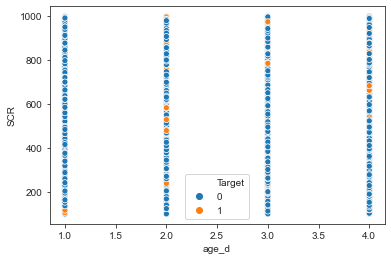

In [185]:
sns.scatterplot(x='age_d', y="SCR", hue = "Target",data=data1,)
plt.show()

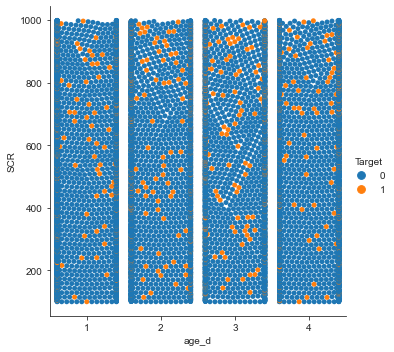

In [186]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "swarm")
plt.show()

In [187]:
sns.set_style('ticks')

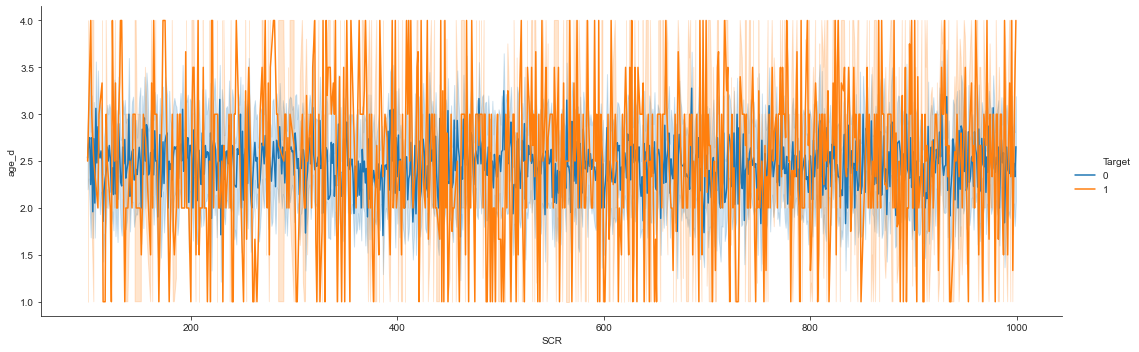

In [188]:
g = sns.relplot(x="SCR", y="age_d", hue = "Target",data=data1, aspect=3, kind = "line")
# g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

## BUCKETING SCR & HOLDING PERIODS

In [189]:
data1['SCRb'] = pd.qcut(data['SCR'], q=5)

In [190]:
data1.SCRb.value_counts()

(99.999, 288.0]    3987
(468.0, 651.0]     3964
(826.0, 999.0]     3956
(651.0, 826.0]     3952
(288.0, 468.0]     3945
Name: SCRb, dtype: int64

In [191]:
data1['HPB'] = pd.qcut(data['Holding_Period'], q=4)

In [192]:
data1.HPB.value_counts()

(0.999, 8.0]    5519
(16.0, 23.0]    4998
(8.0, 16.0]     4791
(23.0, 31.0]    4496
Name: HPB, dtype: int64

In [193]:
data1.head()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_F,Gender_M,Occupation_PROF,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP,"Ageb_(20.999, 30.0]","Ageb_(30.0, 38.0]","Ageb_(38.0, 46.0]","Ageb_(46.0, 55.0]",age_d,SCRb,HPB
0,0,41,91519,38,926,15,0,1,0,0,1,0,0,0,1,0,3,"(826.0, 999.0]","(8.0, 16.0]"
1,0,52,117288,17,768,13,0,1,0,1,0,0,0,0,0,1,4,"(651.0, 826.0]","(8.0, 16.0]"
2,0,31,259827,8,816,5,1,0,0,0,0,1,0,1,0,0,2,"(651.0, 826.0]","(0.999, 8.0]"
3,0,45,26677,14,353,18,1,0,1,0,0,0,0,0,1,0,3,"(288.0, 468.0]","(16.0, 23.0]"
4,0,39,43440,1,751,31,1,0,0,0,0,1,0,0,1,0,3,"(651.0, 826.0]","(23.0, 31.0]"


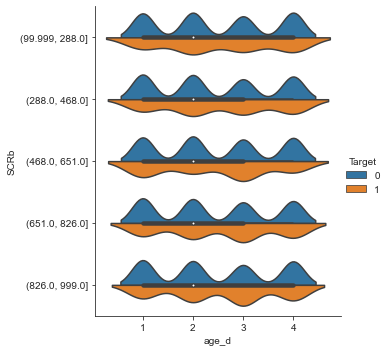

In [194]:
sns.catplot(x="age_d", y="SCRb", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

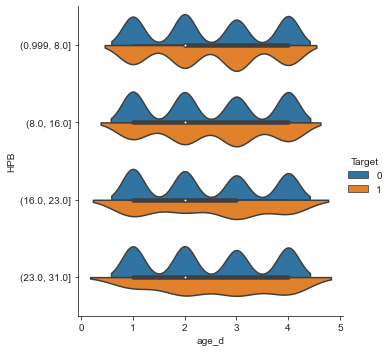

In [195]:
sns.catplot(x="age_d", y="HPB", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.


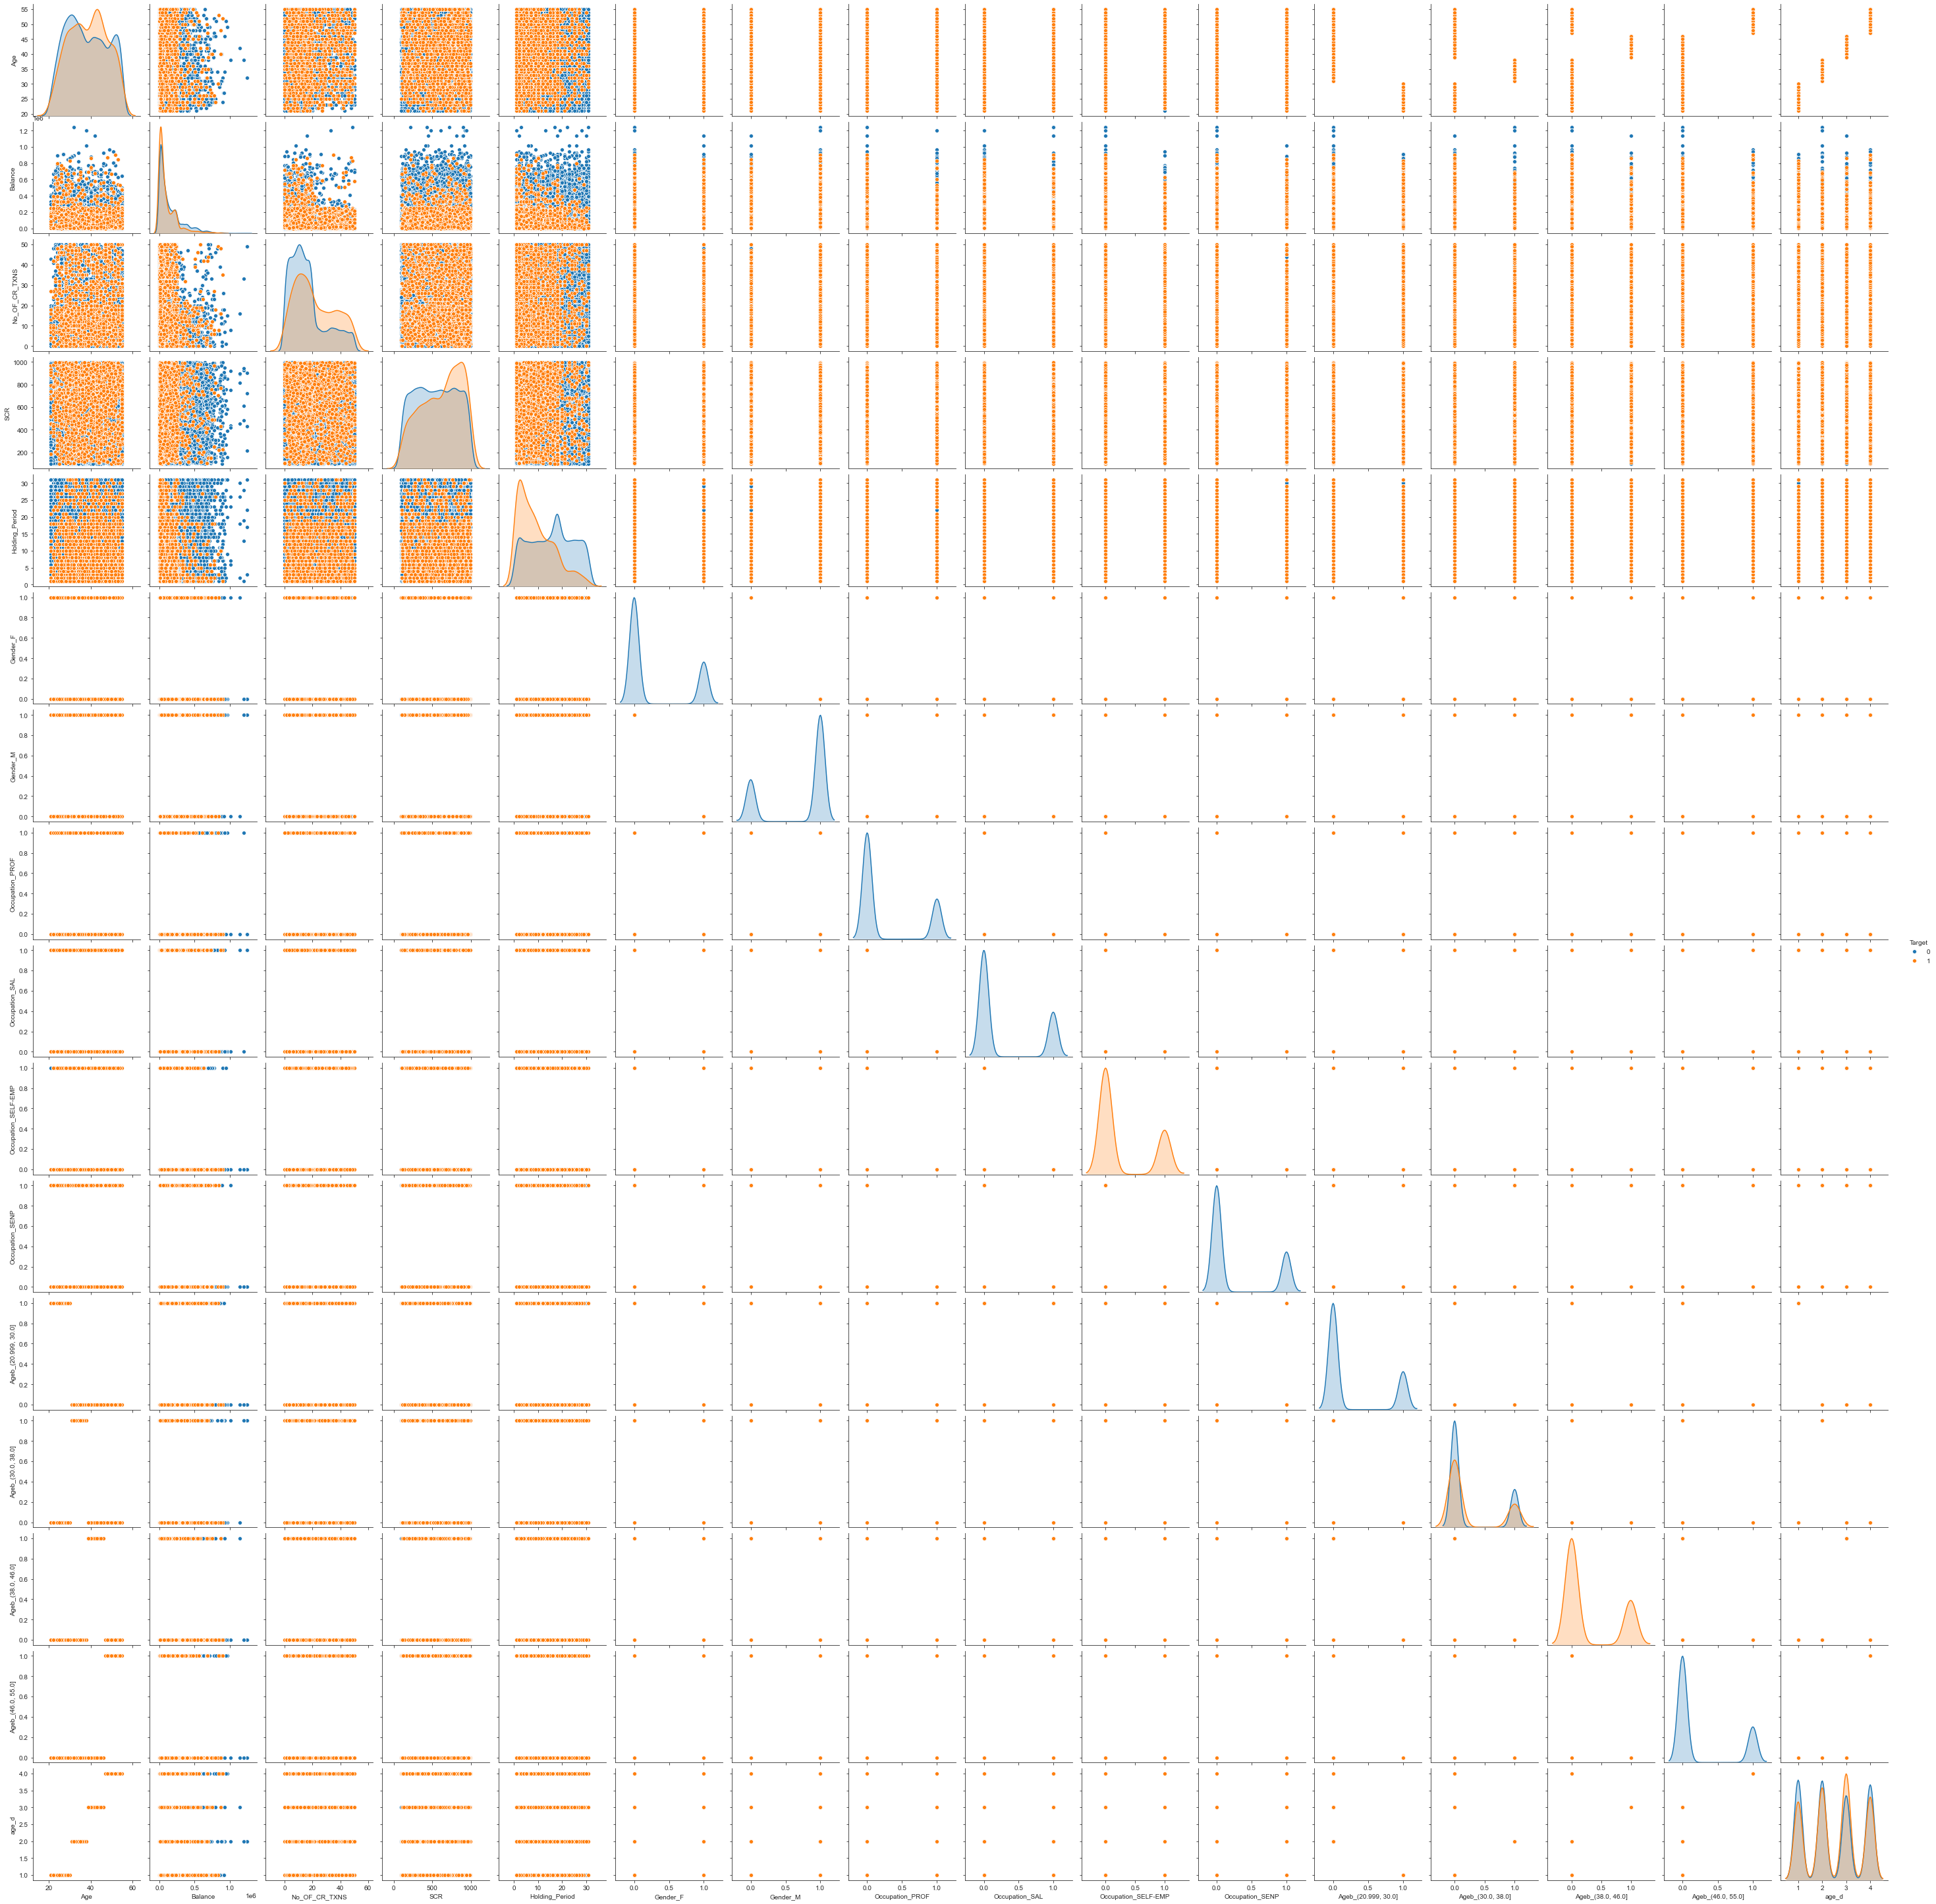

In [196]:
sns.pairplot(data1, hue = 'Target')
plt.show()

## SHAP

In [197]:
import shap

In [198]:
# X_train_summary = shap.kmeans(X_train_orig, 10)

In [199]:
# explainerKNN = shap.KernelExplainer(clf_KNN0.predict,X_train_summary)

In [209]:
# shap_values_KNN_test = explainerKNN.shap_values(X_test_orig)

In [ ]:
# shap.initjs()
# shap.force_plot(explainerKNN.expected_value, shap_values_KNN_test[:1000,:], X_test_orig.iloc[:1000,:])

## LIME

In [ ]:
# import lime
# import lime.lime_tabular

In [ ]:
# lgb_params = {
#     'task': 'train',
#     'boosting_type': 'goss',
#     'objective': 'binary',
#     'metric':'binary_logloss',
#     'metric': {'l2', 'auc'},
#     'num_leaves': 50,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'verbose': None,
#     'num_iteration':100,
#     'num_threads':7,
#     'max_depth':12,
#     'min_data_in_leaf':100,
#     'alpha':0.5}

In [ ]:
# import warnings
# from lime import submodular_pick
# import lightgbm as lgb

# lgb_train = lgb.Dataset(X_train_orig, y_train_orig)
# lgb_eval = lgb.Dataset(X_test_orig, y_test_orig)

# model = lgb.train(lgb_params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=5)
# lime.lime_tabular.LimeTabularExplainer(data[model.feature_name()].astype(int).values,  
# mode='classification',training_labels=data3['Target'],feature_names=model.feature_name())
# # Remember to convert the dataframe to matrix values
# # SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
# sp_obj = submodular_pick.SubmodularPick(explainer,data3[model.feature_name()].values, \
# prob, num_features=5,num_exps_desired=10)

# [exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

In [202]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5, depth=5, rsm=0.98, 
                           loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=42)

In [203]:
cate_features_index = np.where(data.dtypes != float)[0]

In [204]:
model.fit(X_train_orig,y_train_orig,cat_features=cate_features_index,eval_set=(X_test_orig,y_test_orig))

0:	test: 0.7058654	best: 0.7058654 (0)	total: 67.1ms	remaining: 1m 40s
1:	test: 0.7042632	best: 0.7058654 (0)	total: 108ms	remaining: 1m 20s
2:	test: 0.7377569	best: 0.7377569 (2)	total: 154ms	remaining: 1m 16s
3:	test: 0.7377569	best: 0.7377569 (2)	total: 162ms	remaining: 1m
4:	test: 0.7455561	best: 0.7455561 (4)	total: 200ms	remaining: 59.9s
5:	test: 0.7459231	best: 0.7459231 (5)	total: 211ms	remaining: 52.6s
6:	test: 0.7420091	best: 0.7459231 (5)	total: 220ms	remaining: 46.8s
7:	test: 0.7465562	best: 0.7465562 (7)	total: 231ms	remaining: 43s
8:	test: 0.7506792	best: 0.7506792 (8)	total: 241ms	remaining: 40s
9:	test: 0.7478589	best: 0.7506792 (8)	total: 255ms	remaining: 38s
10:	test: 0.7474018	best: 0.7506792 (8)	total: 265ms	remaining: 35.9s
11:	test: 0.7503021	best: 0.7506792 (8)	total: 301ms	remaining: 37.3s
12:	test: 0.7499537	best: 0.7506792 (8)	total: 311ms	remaining: 35.6s
13:	test: 0.7491896	best: 0.7506792 (8)	total: 347ms	remaining: 36.9s
14:	test: 0.7519384	best: 0.7519384

124:	test: 0.8479711	best: 0.8479820 (119)	total: 2.32s	remaining: 25.6s
125:	test: 0.8480193	best: 0.8480193 (125)	total: 2.34s	remaining: 25.6s
126:	test: 0.8479318	best: 0.8480193 (125)	total: 2.36s	remaining: 25.5s
127:	test: 0.8482305	best: 0.8482305 (127)	total: 2.39s	remaining: 25.6s
128:	test: 0.8481880	best: 0.8482305 (127)	total: 2.4s	remaining: 25.5s
129:	test: 0.8480762	best: 0.8482305 (127)	total: 2.41s	remaining: 25.4s
130:	test: 0.8480762	best: 0.8482305 (127)	total: 2.42s	remaining: 25.3s
131:	test: 0.8480721	best: 0.8482305 (127)	total: 2.43s	remaining: 25.2s
132:	test: 0.8479934	best: 0.8482305 (127)	total: 2.45s	remaining: 25.2s
133:	test: 0.8480482	best: 0.8482305 (127)	total: 2.46s	remaining: 25.1s
134:	test: 0.8484339	best: 0.8484339 (134)	total: 2.47s	remaining: 25s
135:	test: 0.8484349	best: 0.8484349 (135)	total: 2.48s	remaining: 24.9s
136:	test: 0.8485260	best: 0.8485260 (136)	total: 2.5s	remaining: 24.8s
137:	test: 0.8485633	best: 0.8485633 (137)	total: 2.52s

240:	test: 0.8542460	best: 0.8542545 (237)	total: 4.37s	remaining: 22.8s
241:	test: 0.8543107	best: 0.8543107 (241)	total: 4.38s	remaining: 22.8s
242:	test: 0.8542310	best: 0.8543107 (241)	total: 4.39s	remaining: 22.7s
243:	test: 0.8542481	best: 0.8543107 (241)	total: 4.42s	remaining: 22.8s
244:	test: 0.8542615	best: 0.8543107 (241)	total: 4.44s	remaining: 22.7s
245:	test: 0.8542346	best: 0.8543107 (241)	total: 4.46s	remaining: 22.7s
246:	test: 0.8542444	best: 0.8543107 (241)	total: 4.49s	remaining: 22.8s
247:	test: 0.8541999	best: 0.8543107 (241)	total: 4.5s	remaining: 22.7s
248:	test: 0.8542496	best: 0.8543107 (241)	total: 4.51s	remaining: 22.7s
249:	test: 0.8543252	best: 0.8543252 (249)	total: 4.53s	remaining: 22.6s
250:	test: 0.8543423	best: 0.8543423 (250)	total: 4.54s	remaining: 22.6s
251:	test: 0.8544474	best: 0.8544474 (251)	total: 4.57s	remaining: 22.6s
252:	test: 0.8542532	best: 0.8544474 (251)	total: 4.58s	remaining: 22.6s
253:	test: 0.8542879	best: 0.8544474 (251)	total: 4.

354:	test: 0.8552764	best: 0.8554136 (352)	total: 6.45s	remaining: 20.8s
355:	test: 0.8552531	best: 0.8554136 (352)	total: 6.46s	remaining: 20.8s
356:	test: 0.8552619	best: 0.8554136 (352)	total: 6.48s	remaining: 20.7s
357:	test: 0.8552816	best: 0.8554136 (352)	total: 6.49s	remaining: 20.7s
358:	test: 0.8552800	best: 0.8554136 (352)	total: 6.5s	remaining: 20.7s
359:	test: 0.8552334	best: 0.8554136 (352)	total: 6.52s	remaining: 20.6s
360:	test: 0.8552847	best: 0.8554136 (352)	total: 6.54s	remaining: 20.6s
361:	test: 0.8552417	best: 0.8554136 (352)	total: 6.58s	remaining: 20.7s
362:	test: 0.8552516	best: 0.8554136 (352)	total: 6.61s	remaining: 20.7s
363:	test: 0.8552857	best: 0.8554136 (352)	total: 6.62s	remaining: 20.7s
364:	test: 0.8553002	best: 0.8554136 (352)	total: 6.63s	remaining: 20.6s
365:	test: 0.8553634	best: 0.8554136 (352)	total: 6.67s	remaining: 20.7s
366:	test: 0.8553655	best: 0.8554136 (352)	total: 6.69s	remaining: 20.7s
367:	test: 0.8553939	best: 0.8554136 (352)	total: 6.

470:	test: 0.8557798	best: 0.8558093 (468)	total: 8.48s	remaining: 18.5s
471:	test: 0.8557840	best: 0.8558093 (468)	total: 8.49s	remaining: 18.5s
472:	test: 0.8557783	best: 0.8558093 (468)	total: 8.53s	remaining: 18.5s
473:	test: 0.8558358	best: 0.8558358 (473)	total: 8.54s	remaining: 18.5s
474:	test: 0.8558596	best: 0.8558596 (474)	total: 8.57s	remaining: 18.5s
475:	test: 0.8558337	best: 0.8558596 (474)	total: 8.58s	remaining: 18.5s
476:	test: 0.8558207	best: 0.8558596 (474)	total: 8.59s	remaining: 18.4s
477:	test: 0.8558565	best: 0.8558596 (474)	total: 8.62s	remaining: 18.4s
478:	test: 0.8558544	best: 0.8558596 (474)	total: 8.63s	remaining: 18.4s
479:	test: 0.8558782	best: 0.8558782 (479)	total: 8.65s	remaining: 18.4s
480:	test: 0.8558207	best: 0.8558782 (479)	total: 8.66s	remaining: 18.4s
481:	test: 0.8558875	best: 0.8558875 (481)	total: 8.68s	remaining: 18.3s
482:	test: 0.8558911	best: 0.8558911 (482)	total: 8.69s	remaining: 18.3s
483:	test: 0.8558979	best: 0.8558979 (483)	total: 8

588:	test: 0.8562737	best: 0.8563058 (580)	total: 11s	remaining: 17s
589:	test: 0.8562737	best: 0.8563058 (580)	total: 11s	remaining: 17s
590:	test: 0.8562758	best: 0.8563058 (580)	total: 11s	remaining: 17s
591:	test: 0.8563141	best: 0.8563141 (591)	total: 11s	remaining: 16.9s
592:	test: 0.8563141	best: 0.8563141 (591)	total: 11.1s	remaining: 16.9s
593:	test: 0.8563125	best: 0.8563141 (591)	total: 11.1s	remaining: 16.9s
594:	test: 0.8563141	best: 0.8563141 (591)	total: 11.1s	remaining: 16.9s
595:	test: 0.8563017	best: 0.8563141 (591)	total: 11.1s	remaining: 16.8s
596:	test: 0.8562980	best: 0.8563141 (591)	total: 11.1s	remaining: 16.8s
597:	test: 0.8563239	best: 0.8563239 (597)	total: 11.1s	remaining: 16.8s
598:	test: 0.8563493	best: 0.8563493 (598)	total: 11.1s	remaining: 16.7s
599:	test: 0.8564078	best: 0.8564078 (599)	total: 11.1s	remaining: 16.7s
600:	test: 0.8564067	best: 0.8564078 (599)	total: 11.2s	remaining: 16.7s
601:	test: 0.8563803	best: 0.8564078 (599)	total: 11.2s	remaining

706:	test: 0.8565118	best: 0.8565170 (703)	total: 12.9s	remaining: 14.4s
707:	test: 0.8565118	best: 0.8565170 (703)	total: 12.9s	remaining: 14.4s
708:	test: 0.8565066	best: 0.8565170 (703)	total: 12.9s	remaining: 14.4s
709:	test: 0.8565015	best: 0.8565170 (703)	total: 12.9s	remaining: 14.3s
710:	test: 0.8565046	best: 0.8565170 (703)	total: 12.9s	remaining: 14.3s
711:	test: 0.8564999	best: 0.8565170 (703)	total: 12.9s	remaining: 14.3s
712:	test: 0.8564999	best: 0.8565170 (703)	total: 12.9s	remaining: 14.3s
713:	test: 0.8565248	best: 0.8565248 (713)	total: 13s	remaining: 14.3s
714:	test: 0.8565512	best: 0.8565512 (714)	total: 13s	remaining: 14.2s
715:	test: 0.8565636	best: 0.8565636 (715)	total: 13s	remaining: 14.2s
716:	test: 0.8565833	best: 0.8565833 (716)	total: 13s	remaining: 14.2s
717:	test: 0.8566003	best: 0.8566003 (717)	total: 13s	remaining: 14.2s
718:	test: 0.8565915	best: 0.8566003 (717)	total: 13s	remaining: 14.1s
719:	test: 0.8565915	best: 0.8566003 (717)	total: 13s	remaining

827:	test: 0.8562737	best: 0.8566003 (717)	total: 14.7s	remaining: 12s
828:	test: 0.8562763	best: 0.8566003 (717)	total: 14.7s	remaining: 11.9s
829:	test: 0.8562768	best: 0.8566003 (717)	total: 14.8s	remaining: 11.9s
830:	test: 0.8562292	best: 0.8566003 (717)	total: 14.8s	remaining: 11.9s
831:	test: 0.8561572	best: 0.8566003 (717)	total: 14.8s	remaining: 11.9s
832:	test: 0.8561484	best: 0.8566003 (717)	total: 14.8s	remaining: 11.9s
833:	test: 0.8561407	best: 0.8566003 (717)	total: 14.8s	remaining: 11.8s
834:	test: 0.8561500	best: 0.8566003 (717)	total: 14.8s	remaining: 11.8s
835:	test: 0.8561086	best: 0.8566003 (717)	total: 14.9s	remaining: 11.8s
836:	test: 0.8560925	best: 0.8566003 (717)	total: 14.9s	remaining: 11.8s
837:	test: 0.8561044	best: 0.8566003 (717)	total: 15s	remaining: 11.8s
838:	test: 0.8561075	best: 0.8566003 (717)	total: 15s	remaining: 11.8s
839:	test: 0.8561117	best: 0.8566003 (717)	total: 15s	remaining: 11.8s
840:	test: 0.8561686	best: 0.8566003 (717)	total: 15s	remai

942:	test: 0.8557695	best: 0.8566003 (717)	total: 16.5s	remaining: 9.73s
943:	test: 0.8557881	best: 0.8566003 (717)	total: 16.5s	remaining: 9.71s
944:	test: 0.8557933	best: 0.8566003 (717)	total: 16.5s	remaining: 9.7s
945:	test: 0.8557866	best: 0.8566003 (717)	total: 16.5s	remaining: 9.68s
946:	test: 0.8557995	best: 0.8566003 (717)	total: 16.5s	remaining: 9.66s
947:	test: 0.8558088	best: 0.8566003 (717)	total: 16.6s	remaining: 9.66s
948:	test: 0.8558052	best: 0.8566003 (717)	total: 16.6s	remaining: 9.64s
949:	test: 0.8557773	best: 0.8566003 (717)	total: 16.6s	remaining: 9.63s
950:	test: 0.8557871	best: 0.8566003 (717)	total: 16.6s	remaining: 9.61s
951:	test: 0.8558047	best: 0.8566003 (717)	total: 16.7s	remaining: 9.59s
952:	test: 0.8558021	best: 0.8566003 (717)	total: 16.7s	remaining: 9.57s
953:	test: 0.8558109	best: 0.8566003 (717)	total: 16.7s	remaining: 9.55s
954:	test: 0.8558052	best: 0.8566003 (717)	total: 16.7s	remaining: 9.53s
955:	test: 0.8558161	best: 0.8566003 (717)	total: 16

1061:	test: 0.8555966	best: 0.8566003 (717)	total: 18.6s	remaining: 7.66s
1062:	test: 0.8556064	best: 0.8566003 (717)	total: 18.6s	remaining: 7.64s
1063:	test: 0.8556023	best: 0.8566003 (717)	total: 18.6s	remaining: 7.63s
1064:	test: 0.8555930	best: 0.8566003 (717)	total: 18.7s	remaining: 7.62s
1065:	test: 0.8555645	best: 0.8566003 (717)	total: 18.7s	remaining: 7.6s
1066:	test: 0.8555692	best: 0.8566003 (717)	total: 18.7s	remaining: 7.58s
1067:	test: 0.8555583	best: 0.8566003 (717)	total: 18.7s	remaining: 7.56s
1068:	test: 0.8555557	best: 0.8566003 (717)	total: 18.8s	remaining: 7.57s
1069:	test: 0.8555495	best: 0.8566003 (717)	total: 18.8s	remaining: 7.55s
1070:	test: 0.8555624	best: 0.8566003 (717)	total: 18.8s	remaining: 7.53s
1071:	test: 0.8555433	best: 0.8566003 (717)	total: 18.8s	remaining: 7.51s
1072:	test: 0.8555474	best: 0.8566003 (717)	total: 18.8s	remaining: 7.49s
1073:	test: 0.8555459	best: 0.8566003 (717)	total: 18.8s	remaining: 7.47s
1074:	test: 0.8555428	best: 0.8566003 (

1180:	test: 0.8552094	best: 0.8566003 (717)	total: 20.6s	remaining: 5.57s
1181:	test: 0.8552016	best: 0.8566003 (717)	total: 20.6s	remaining: 5.55s
1182:	test: 0.8552078	best: 0.8566003 (717)	total: 20.6s	remaining: 5.53s
1183:	test: 0.8552140	best: 0.8566003 (717)	total: 20.7s	remaining: 5.51s
1184:	test: 0.8552202	best: 0.8566003 (717)	total: 20.7s	remaining: 5.49s
1185:	test: 0.8552083	best: 0.8566003 (717)	total: 20.7s	remaining: 5.48s
1186:	test: 0.8552171	best: 0.8566003 (717)	total: 20.7s	remaining: 5.46s
1187:	test: 0.8552151	best: 0.8566003 (717)	total: 20.7s	remaining: 5.44s
1188:	test: 0.8552011	best: 0.8566003 (717)	total: 20.8s	remaining: 5.43s
1189:	test: 0.8551633	best: 0.8566003 (717)	total: 20.8s	remaining: 5.42s
1190:	test: 0.8551566	best: 0.8566003 (717)	total: 20.8s	remaining: 5.4s
1191:	test: 0.8551711	best: 0.8566003 (717)	total: 20.8s	remaining: 5.38s
1192:	test: 0.8551938	best: 0.8566003 (717)	total: 20.9s	remaining: 5.37s
1193:	test: 0.8551959	best: 0.8566003 (

1295:	test: 0.8550831	best: 0.8566003 (717)	total: 22.8s	remaining: 3.59s
1296:	test: 0.8550825	best: 0.8566003 (717)	total: 22.8s	remaining: 3.58s
1297:	test: 0.8550805	best: 0.8566003 (717)	total: 22.9s	remaining: 3.56s
1298:	test: 0.8550913	best: 0.8566003 (717)	total: 22.9s	remaining: 3.54s
1299:	test: 0.8550893	best: 0.8566003 (717)	total: 22.9s	remaining: 3.52s
1300:	test: 0.8550572	best: 0.8566003 (717)	total: 22.9s	remaining: 3.5s
1301:	test: 0.8550546	best: 0.8566003 (717)	total: 22.9s	remaining: 3.49s
1302:	test: 0.8550986	best: 0.8566003 (717)	total: 23s	remaining: 3.47s
1303:	test: 0.8551079	best: 0.8566003 (717)	total: 23s	remaining: 3.46s
1304:	test: 0.8551027	best: 0.8566003 (717)	total: 23s	remaining: 3.44s
1305:	test: 0.8551038	best: 0.8566003 (717)	total: 23s	remaining: 3.42s
1306:	test: 0.8551069	best: 0.8566003 (717)	total: 23.1s	remaining: 3.4s
1307:	test: 0.8551001	best: 0.8566003 (717)	total: 23.1s	remaining: 3.39s
1308:	test: 0.8550991	best: 0.8566003 (717)	tota

1415:	test: 0.8545758	best: 0.8566003 (717)	total: 25.1s	remaining: 1.49s
1416:	test: 0.8546037	best: 0.8566003 (717)	total: 25.1s	remaining: 1.47s
1417:	test: 0.8546120	best: 0.8566003 (717)	total: 25.1s	remaining: 1.45s
1418:	test: 0.8546120	best: 0.8566003 (717)	total: 25.1s	remaining: 1.43s
1419:	test: 0.8546161	best: 0.8566003 (717)	total: 25.1s	remaining: 1.42s
1420:	test: 0.8546203	best: 0.8566003 (717)	total: 25.2s	remaining: 1.4s
1421:	test: 0.8546151	best: 0.8566003 (717)	total: 25.2s	remaining: 1.38s
1422:	test: 0.8545804	best: 0.8566003 (717)	total: 25.2s	remaining: 1.36s
1423:	test: 0.8545556	best: 0.8566003 (717)	total: 25.2s	remaining: 1.34s
1424:	test: 0.8545519	best: 0.8566003 (717)	total: 25.2s	remaining: 1.33s
1425:	test: 0.8545390	best: 0.8566003 (717)	total: 25.2s	remaining: 1.31s
1426:	test: 0.8545292	best: 0.8566003 (717)	total: 25.2s	remaining: 1.29s
1427:	test: 0.8545204	best: 0.8566003 (717)	total: 25.2s	remaining: 1.27s
1428:	test: 0.8545188	best: 0.8566003 (

In [205]:
test = pd.read_csv("F:\\IBPA_IIM_FinalProject\\test_data.csv")
pred = model.predict(test)


In [206]:
pred[:40]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [207]:
from sklearn.metrics import confusion_matrix

In [208]:
confusion_matrix(y_test_orig, pred)

array([[4313,  211],
       [ 409,   18]], dtype=int64)

In [ ]:
[1][1] = No of non loan takers
[1][2] = 
[2][1] = 
[2][2] = 